In [1]:
from ProbaData import *

from supreshelper import *

from SimpleCNN import SimpleCNN

import tensorflow as tf
import time

from IPython.display import clear_output

In [2]:
data_dir = "DataGenerated/"
ds = ProbaVDataset("DataGenerated/")

In [3]:
def _parse_function(example_proto):
    keys_to_features = {'all':tf.io.FixedLenFeature((384, 384*3), tf.float32)}
    parsed_features = tf.io.parse_single_example(example_proto, keys_to_features)
    return ds.load_train_image(parsed_features['all'])

### Define our datasets from TFrecords

In [34]:
batch_size = 2

train_dataset = tf.data.TFRecordDataset(glob(data_dir +  "train/*/*/all.tfrecords"))
train_dataset = train_dataset.shuffle(len(glob(data_dir +  "train/*/*/all.tfrecords")))
train_dataset = train_dataset.repeat()  
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE) 
train_dataset = train_dataset.batch(batch_size)

In [35]:
dev_dataset = tf.data.TFRecordDataset(glob(data_dir +  "dev/*/*/all.tfrecords"))
train_dataset = train_dataset.shuffle(len(glob(data_dir +  "dev/*/*/all.tfrecords")))
dev_dataset = dev_dataset.repeat()  
dev_dataset = dev_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE) 
dev_dataset = dev_dataset.batch(batch_size)

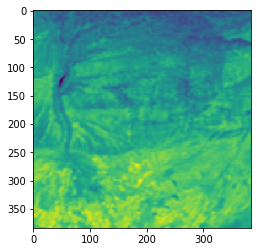

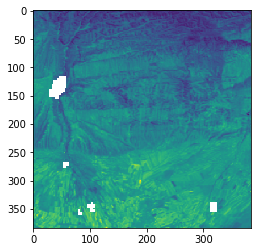

In [6]:
for a in train_dataset.take(1):
    plt.figure()
    plt.imshow(a[0][0][:,:,0])
    plt.figure()
    plt.imshow(a[1][0][:,:,0])

In [7]:
model = SimpleCNN()

In [8]:
import tensorflow.keras.backend as K

In [263]:
def cMSE(hr, sr):

    # apply the quality mask
    #obs = tf.equal(hr, 0.05)
    obs = tf.where(tf.math.is_nan(hr), True, False)
    clr = tf.math.logical_not(obs)
    _hr = tf.boolean_mask(hr, clr )
    _sr = tf.boolean_mask(sr, clr )

    # calculate the bias in brightness b
    pixel_diff = _hr - _sr
    b = K.mean(pixel_diff)

    # calculate the corrected clear mean-square error
    pixel_diff -= b
    cMse = K.mean(pixel_diff * pixel_diff)

    return cMse

In [255]:
def clearMSE(generated, hr):
    """As defined in https://kelvins.esa.int/proba-v-super-resolution/scoring/
    
        MSE loss that takes into account brightness and stuff TODO
    """
    quality_map = tf.where(tf.math.is_nan(hr), 0.0, hr)
    generated_ = tf.math.multiply(generated, quality_map)
    hr_ = tf.math.multiply(hr, quality_map)
    
    # calculate bias brightness
    bias = tf.math.reduce_mean(generated_ - hr_) # TODO divide by number #bias
    loss = tf.math.reduce_mean(tf.pow(hr_ - (generated_ - bias), 2)) # TODO divide by number #bias

    return loss

In [260]:
a = tf.random.uniform([384,384,1], dtype=tf.float32)
b = tf.random.uniform([384,384,1], dtype=tf.float32)
clearMSE(a,b)

<tf.Tensor: id=761001, shape=(), dtype=float32, numpy=0.054311924>

In [265]:
cMSE(b, a)

<tf.Tensor: id=761269, shape=(), dtype=float32, numpy=0.16634242>

In [266]:
from tensorflow.keras.optimizers import Adam
LAMBDA = 100

In [267]:
EPOCHS = 5000
optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [268]:
checkpoint_dir = './TrainingCheckpointSimple'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 model=model.simpleCNN)

In [269]:
mse_loss = tf.keras.losses.MeanSquaredError()
msle_loss = tf.keras.losses.MeanSquaredLogarithmicError()

In [270]:
@tf.function
def compute_loss(lr, hr):
    gen_output = model.simpleCNN(lr, training=True)
    
    #mse = mse_loss(lr, hr)
    # cMSE(gen_output, hr)
    return cMSE(hr, gen_output)

In [271]:
compute_loss(lr, hr)

<tf.Tensor: id=761584, shape=(), dtype=float32, numpy=0.10975722>

In [272]:
@tf.function
def train_step(lr, hr):
    with tf.GradientTape() as model_tape:
        loss = compute_loss(lr, hr)
        # We compute gradient for each part
        model_gardients = model_tape.gradient(loss, model.simpleCNN.trainable_variables)
        # We apply the gradient to the variables, tf2.0 way
        optimizer.apply_gradients(zip(model_gardients, model.simpleCNN.trainable_variables))

In [273]:
def show_dev_pred(generator, lr, hr):
    predicted = generator.predict(lr)
    plt.figure(figsize=(15,15))
    
    display_list = [lr[0][:,:,0], predicted[0][:,:,0], hr[0][:,:,0]]
    title = ['Input Image', 'Predicted Image', 'Real image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()
    

In [274]:
losses_record = []

def train(train_dataset, dev_dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        if (epoch + 1) % 50 == 0:
            for lr, hr in dev_dataset.take(1):
                print("Showing current result")
                show_dev_pred(model.simpleCNN, lr, hr)
            
        loss = 0
        for lr, hr in dev_dataset:
            loss += compute_loss(lr, hr)

        losses_record.append(loss)
        
        for lr, hr in train_dataset:
            train_step(lr, hr)
        
        # saving (checkpoint) the model every 100 epochs
        if (epoch + 1) % 100 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        if (epoch + 1) % 1 == 0:
            print('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
            print('current val losses: ' + str(loss))
            print('=============================================')

In [ ]:
train(train_dataset, dev_dataset, EPOCHS)